Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycircular as pycircular
from scipy.stats import chi2_contingency
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)

Unindo os dataframes

In [2]:
df_channels = pd.read_csv(r'bases\channels.csv')
df_deliveries = pd.read_csv(r'bases\deliveries.csv')
df_drivers = pd.read_csv(r'bases\drivers.csv')
df_hubs = pd.read_csv(r'bases\hubs.csv')
df_orders = pd.read_csv(r'bases\orders.csv')
df_stores = pd.read_csv(r'bases\stores.csv')
df_payments = pd.read_csv(r'bases\payments.csv')

df = pd.merge(df_orders, df_stores, on='store_id')
df = pd.merge(df, df_hubs, on='hub_id')
df = pd.merge(df, df_channels, on='channel_id')
df = pd.merge(df, df_payments, on='payment_order_id')
df = pd.merge(df, df_deliveries, on='delivery_order_id')
df = pd.merge(df, df_drivers, on='driver_id')

df.shape

(287459, 48)

In [3]:
print(df.columns)

Index(['order_id', 'store_id', 'channel_id', 'payment_order_id',
       'delivery_order_id', 'order_status', 'order_amount',
       'order_delivery_fee', 'order_delivery_cost', 'order_created_hour',
       'order_created_minute', 'order_created_day', 'order_created_month',
       'order_moment_created', 'order_moment_accepted', 'order_moment_ready',
       'order_moment_collected', 'order_moment_in_expedition',
       'order_moment_delivering', 'order_moment_delivered',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'hub_id',
       'store_segment', 'store_plan_price', 'store_latitude',
       'store_longitude', 'hub_city', 'hub_latitude', 'hub_longitude',
       'channel_type', 'payment_id', 'payment_amount', 'payment_fee',
       'payment_method', 'payment_status', 'de

In [17]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
order_id,215946.0,82105757.224264,68410055.0,76148637.5,82885660.0,87904480.75,93139799.0,7048877.06835
order_amount,215946.0,88.791656,0.0,38.0,65.0,111.0,15000.0,118.405779
order_delivery_fee,215946.0,5.522793,0.0,0.0,6.0,11.0,990.0,5.710961
order_delivery_cost,215946.0,6.920633,0.0,5.0,7.0,8.0,109.0,2.379256
order_created_hour,215946.0,16.939508,0.0,15.0,17.0,22.0,23.0,6.047609
order_created_minute,215946.0,29.344734,0.0,14.0,29.0,44.0,59.0,17.222617
order_created_day,215946.0,16.075051,1.0,9.0,16.0,24.0,31.0,8.714806
order_created_month,215946.0,2.654539,1.0,2.0,3.0,4.0,4.0,1.099831
order_moment_created,215946,2021-03-07 08:04:38.129388800,2021-01-01 02:32:51,2021-02-07 00:16:31,2021-03-11 14:44:50,2021-04-03 20:49:41.500000,2021-04-30 23:59:26,NaN
order_moment_finished,215946,2021-03-07 09:01:13.881035264,2021-01-01 14:50:20,2021-02-07 01:08:34.249999872,2021-03-11 15:38:59,2021-04-03 21:40:13.750000128,2021-05-01 23:25:01,NaN


# Limpeza Inicial

In [3]:
grupo_pagamento = {
'DEBIT': 'CARD',
'CREDIT': 'CARD',
'DEBIT_STORE': 'CARD',
'CREDIT_STORE': 'CARD',
'INSTALLMENT_CREDIT_STORE': 'CARD',
'MEAL_BENEFIT': 'OTHER',
'STORE_DIRECT_PAYMENT': 'OTHER',
'PAYMENT_LINK': 'OTHER',
'MONEY': 'OTHER',
'BANK_TRANSFER_DC': 'OTHER',
'VOUCHER_DC': 'VOUCHER',
'VOUCHER_OL': 'VOUCHER',
'VOUCHER_STORE': 'VOUCHER'
}

def preparacao_inicial(df):

    #Retirar colunas não importantes
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
        'order_moment_collected', 'order_moment_in_expedition',
        'order_moment_delivering', 'order_moment_delivered'])


    #Retirar pedidos cancelados, que estão sendo entregues e que não foram pagos
    df = df[~df['order_status'].isin(['CANCELED'])]
    df = df[~df['delivery_status'].isin(['DELIVERING'])]
    df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status','payment_fee'])

    #Tratamento dos dados nulos
    df = df.dropna(subset=['delivery_distance_meters','order_metric_cycle_time','order_metric_transit_time'])

    # Preencher os valores nulos com a média da coluna
    df['store_latitude'] = df['store_latitude'].fillna(df['store_latitude'].mean())
    df['store_longitude'] = df['store_longitude'].fillna(df['store_longitude'].mean())

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

    #Valores inconsistentes
    df = df.drop_duplicates()
    df = df.loc[df['order_metric_transit_time'] >= 0]
    df = df.loc[df['order_created_hour'] >= 0]
    df = df.loc[df['order_created_minute'] >= 0]
    df = df.loc[df['order_created_month'] >= 0]
    df = df.loc[df['order_created_day'] >= 0]
    df = df.loc[df['order_created_hour'] <= 24]
    df = df.loc[df['order_created_minute'] <= 60]
    df = df.loc[df['order_created_day'] <= 31]
    df = df.loc[df['order_created_month'] <= 12]
    df = df.loc[df['order_metric_walking_time'] >= 0]
    df = df.loc[df['order_metric_paused_time'] >= 0]
    df = df.loc[df['order_metric_collected_time'] >= 0]
    
    return df

In [4]:
df = preparacao_inicial(df)

# Função para calcular outliers
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame




outlier_df = conta_outliers(df)
print(outlier_df)

                               Coluna  Outliers  Porcentagem       lim_inf  \
0                            order_id         0     0.000000  5.882854e+07   
1                        order_amount     11646     5.032213 -7.450000e+01   
2                  order_delivery_fee        64     0.027654 -1.650000e+01   
3                 order_delivery_cost      9072     3.919993  5.000000e-01   
4                  order_created_hour     20224     8.738749  4.500000e+00   
5                order_created_minute         0     0.000000 -3.100000e+01   
6                   order_created_day         0     0.000000 -1.350000e+01   
7                 order_created_month         0     0.000000 -1.000000e+00   
8         order_metric_collected_time     14644     6.327643 -3.000000e+00   
9            order_metric_paused_time     20162     8.711959 -5.000000e+00   
10       order_metric_production_time      9079     3.923017 -9.000000e+00   
11          order_metric_walking_time     10859     4.692152 -2.

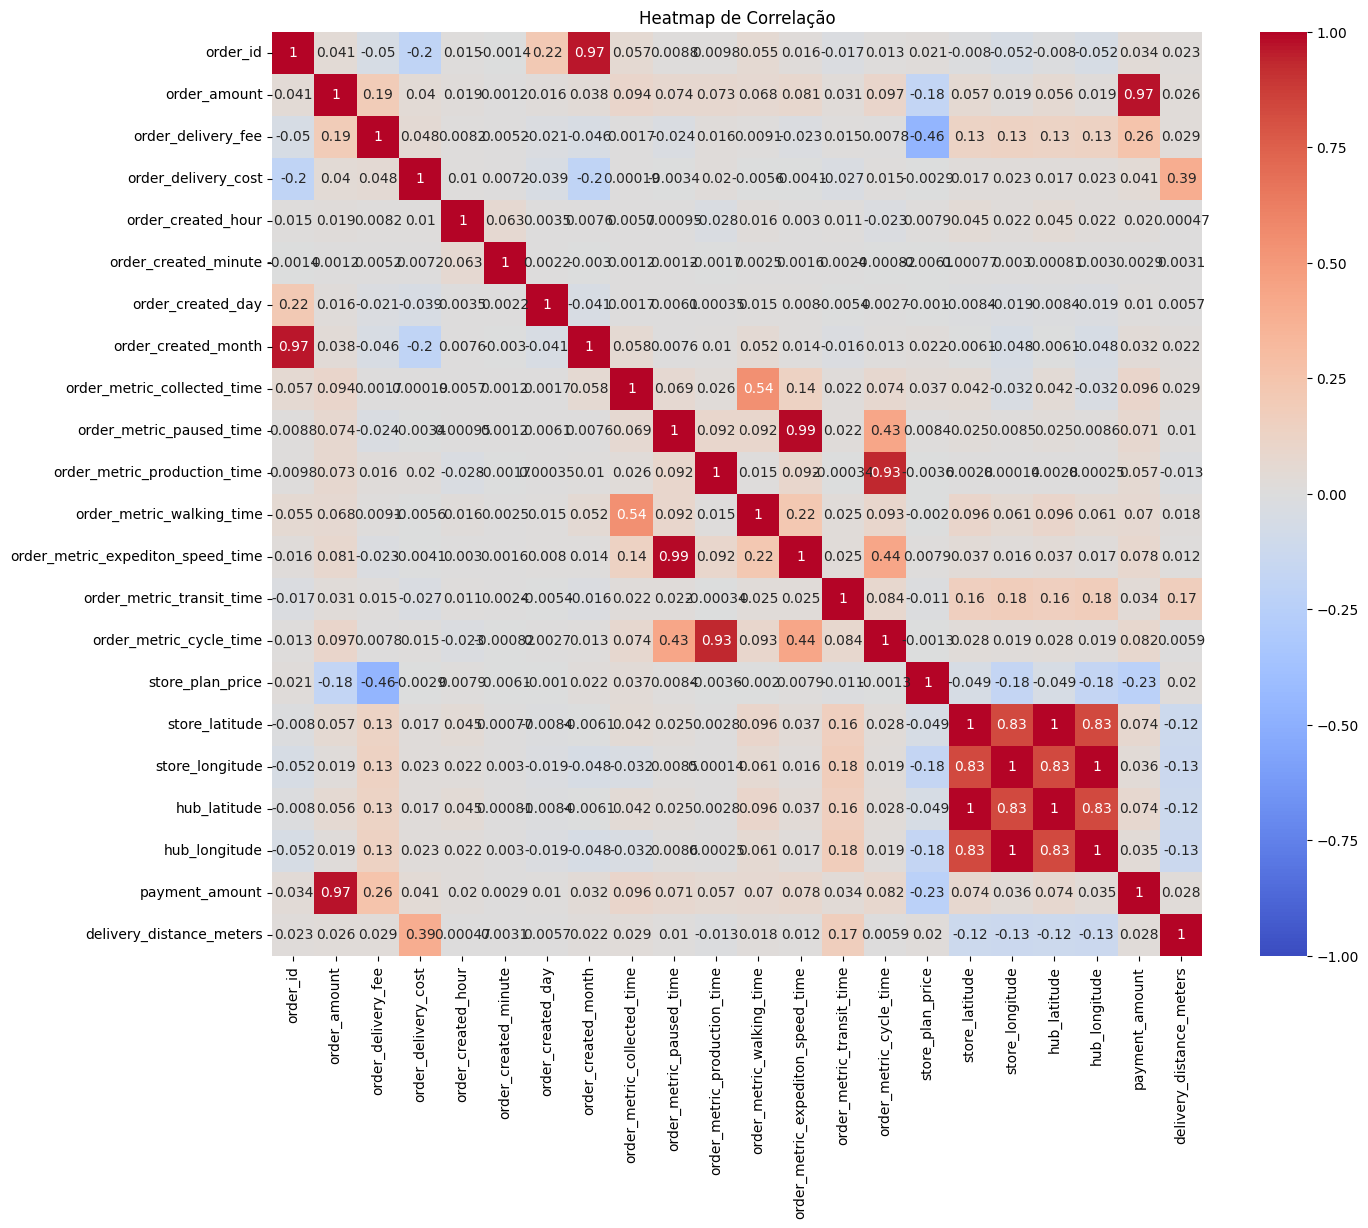

In [30]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df.select_dtypes(include=["int","float"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação')
plt.show()

# Order_metrics

Para os order_metrics de menores expressão (média dos valores menores que 8 minutos), seu valor de soma no tempo total será a ESCOLHER.

No final ver se vale mais a pena (mse_score) usar a média ou mediana

In [5]:
#Médias
avg_walking = df['order_metric_walking_time'].mean()
avg_collected = df['order_metric_collected_time'].mean()

median = avg_walking + avg_collected

# Order_metric_production_time

In [6]:
colunas_production = ['order_created_hour','order_created_minute','channel_type','payment_method','order_delivery_fee','payment_amount','store_longitude','store_latitude','store_plan_price','order_amount','order_metric_production_time']

df_production = df[colunas_production]
df_production = df_production.dropna(subset=['order_metric_production_time'])

df_production = df_production.loc[df_production['order_metric_production_time'] <= 43]
# df_production = df_production.dropna(subset=['order_delivery_cost','order_metric_production_time'])
df_production['store_plan_price'] = df_production['store_plan_price'].fillna(0.0)

def troca1(x):
    if x == 'ONLINE':
        return 0
    elif x == 'VOUCHER':
        return 1
    elif x == 'CARD':
        return 2
    else:
        return 3
    
df_production['payment_method'] = df_production['payment_method'].apply(lambda x: troca1(x))

def troca2(x):
    if x == 'MARKETPLACE':
        return 0
    else:
        return 1
    
df_production['channel_type'] = df_production['channel_type'].apply(lambda x: troca2(x))

# Calculando a representação circular para as horas
df_production['hour_angle'] = (df_production['order_created_hour'] % 12) * 30 + (df_production['order_created_minute'] / 60) * 30
# Normalizando os ângulos para o intervalo [0, 360)
df_production['hour_angle'] = df_production['hour_angle'] % 360

colunas = df_production.columns.tolist()

# Mover 'coluna_alvo' para o início da lista
colunas.insert(0, colunas.pop(colunas.index('hour_angle')))

# Reorganizar as colunas no DataFrame
df_production = df_production[colunas]

df_production = df_production.drop(columns=['order_created_hour','order_created_minute'])

In [10]:
outlier_df = conta_outliers(df_production)
print(outlier_df)

                          Coluna  Outliers  Porcentagem    lim_inf     lim_sup
0                   channel_type     17048     7.595659   0.000000    0.000000
1                 payment_method     49067    21.861578   0.000000    0.000000
2             order_delivery_fee        37     0.016485 -16.500000   27.500000
3                  hub_longitude         0     0.000000 -51.756042  -38.321789
4                   hub_latitude     39492    17.595480 -24.602667  -21.990208
5                 payment_amount      9036     4.025949 -96.462500  246.677500
6                store_longitude         0     0.000000 -51.761425  -38.321065
7                 store_latitude     39473    17.587015 -24.597762  -21.998383
8               store_plan_price         0     0.000000 -73.500000  122.500000
9                   order_amount     11006     4.903673 -73.000000  223.000000
10           order_delivery_cost      8483     3.779562   0.500000   12.500000
11  order_metric_production_time      2812     1.252

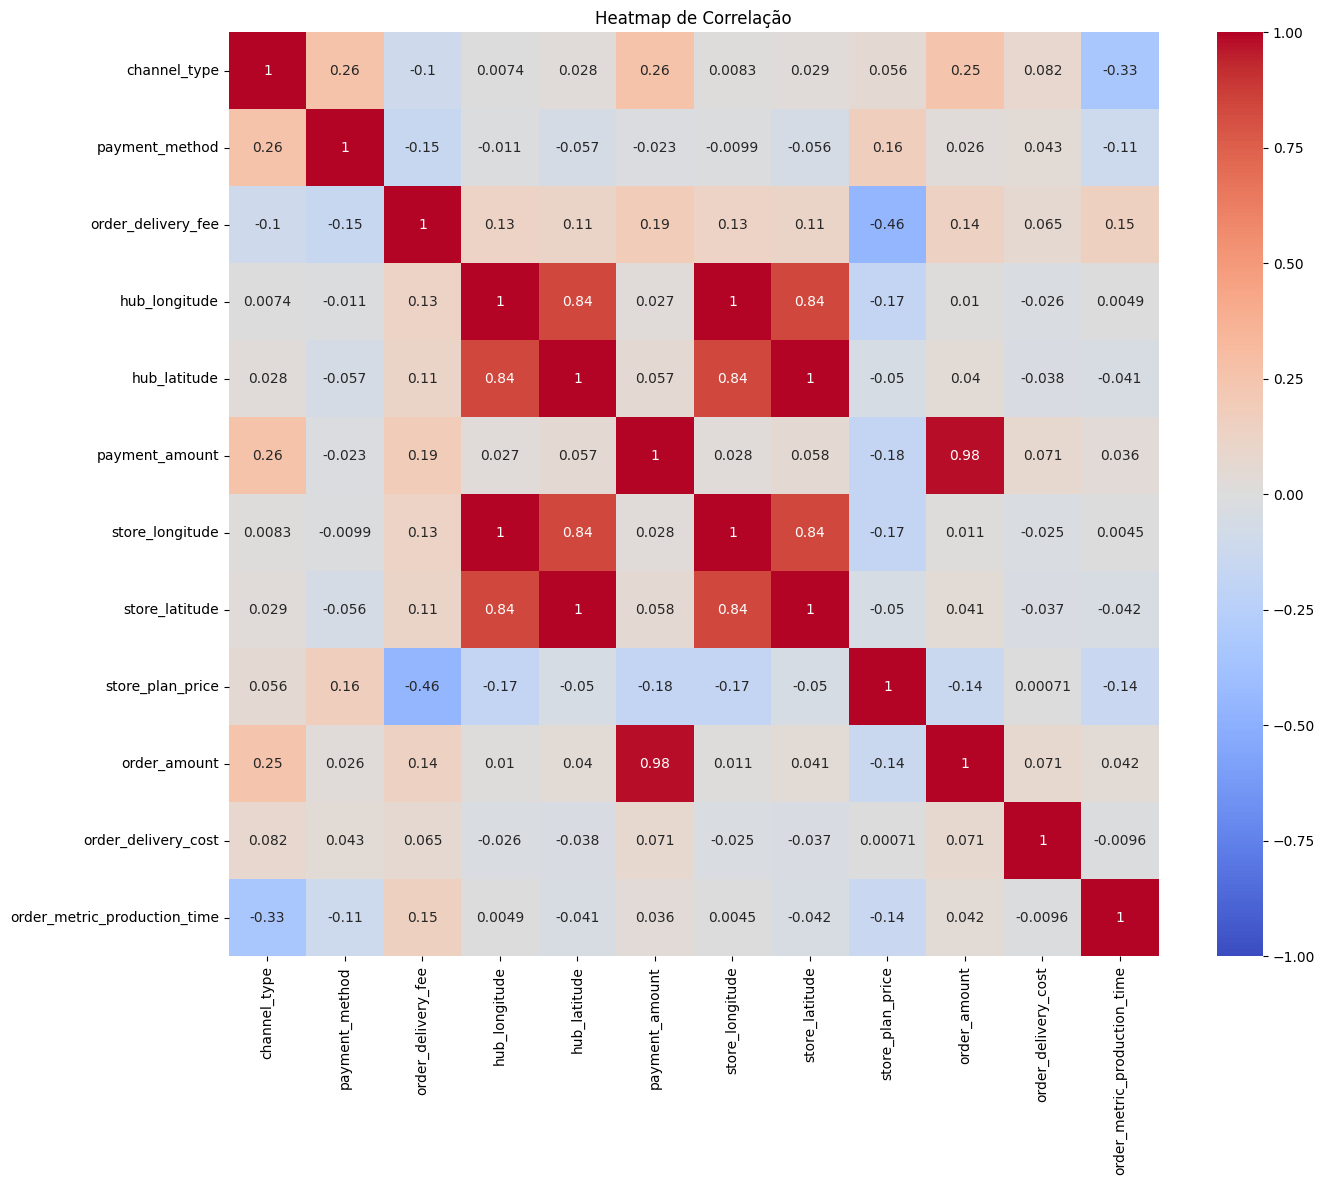

In [7]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df_production.select_dtypes(include=["int","float"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação')
plt.show()

In [7]:
print(df_production.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_production_time = dados.pop("order_metric_production_time")
    return dados, order_metric_production_time

tam_div = round(0.8 * len(df_production)) # Tamanho da separação
tab_treino = df_production.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_production.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]


modelo_production = RandomForestRegressor(n_estimators=100,max_depth=15, min_samples_split=5, min_samples_leaf=4,  random_state=42)

modelo_production.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_production.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['hour_angle', 'channel_type', 'payment_method', 'order_delivery_fee',
       'payment_amount', 'store_longitude', 'store_latitude',
       'store_plan_price', 'order_amount', 'order_metric_production_time'],
      dtype='object')
MSE: 50.775777920123105
R²: 0.36739219749645213


# Order_metric_expediton_speed_time

In [8]:
colunas_exped = ['payment_method','channel_type','hub_longitude','store_segment','order_created_month','order_created_day','order_created_minute','order_created_hour','order_delivery_cost','store_latitude','store_longitude','order_delivery_fee', 'driver_type', 'store_plan_price','order_metric_expediton_speed_time']


df_exped = df[colunas_exped]
df_exped = df_exped.dropna(subset=['order_metric_expediton_speed_time'])

df_exped = df_exped.loc[df_exped['order_metric_expediton_speed_time'] <= 25]

def type(x):
    if x == 'FREELANCE':
        return 0
    else:
        return 1
    
df_exped['driver_type'] = df_exped['driver_type'].apply(lambda x: type(x))

def troca3(x):
    if x == 'FOOD':
        return 0
    else:
        return 1
    
df_exped['store_segment'] = df_exped['store_segment'].apply(lambda x: troca3(x))

def troca2(x):
    if x == 'MARKETPLACE':
        return 0
    else:
        return 1
    
df_exped['channel_type'] = df_exped['channel_type'].apply(lambda x: troca2(x))

def troca1(x):
    if x == 'ONLINE':
        return 0
    elif x == 'VOUCHER':
        return 1
    elif x == 'CARD':
        return 2
    else:
        return 3
    
df_exped['payment_method'] = df_exped['payment_method'].apply(lambda x: troca1(x))

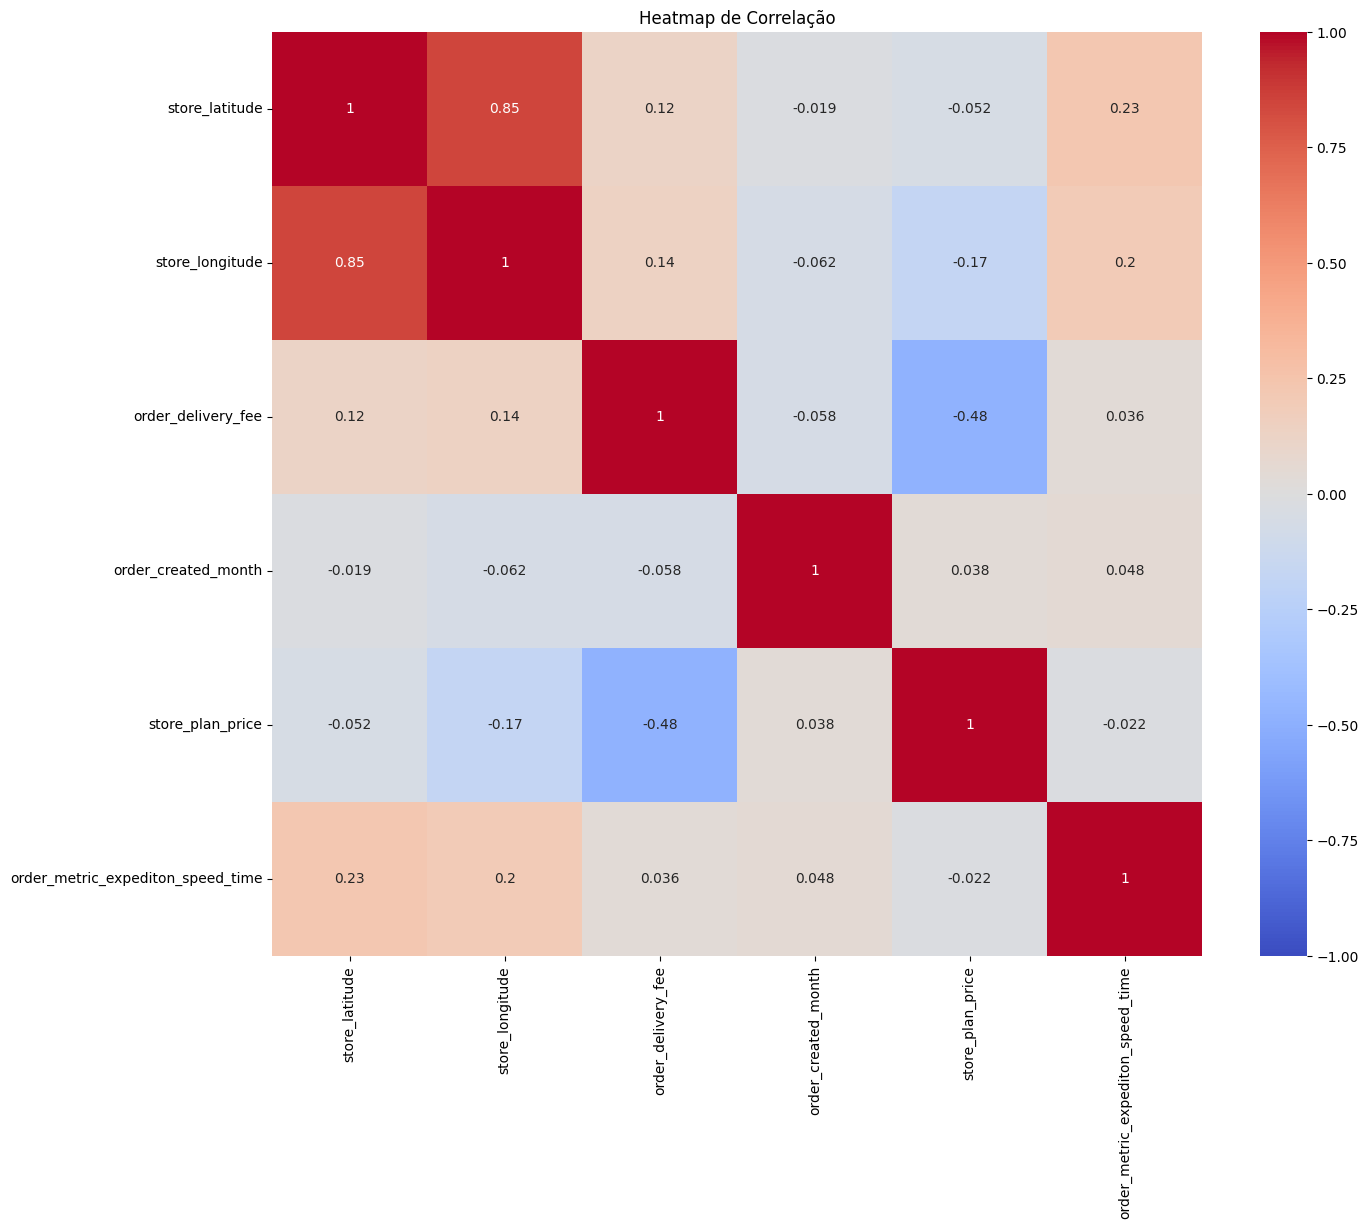

In [77]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df_exped.select_dtypes(include=["int","float"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação')
plt.show()

In [78]:
nomes_colunas_numericas = df_exped.select_dtypes(exclude=['object','datetime']).columns

for coluna in nomes_colunas_numericas:
    data1 = df_exped[coluna]
    data2 = df_exped['order_metric_expediton_speed_time']

    t_statistic, p_value = ttest_ind(data1, data2)

    print("\n")
    print(coluna)
    print("Estatística t:", t_statistic)
    print("Valor p:", p_value)



store_latitude
Estatística t: -2994.2679029758106
Valor p: 0.0


store_longitude
Estatística t: -4872.093621555128
Valor p: 0.0


order_delivery_fee
Estatística t: -96.62890839747254
Valor p: 0.0


order_created_month
Estatística t: -448.7918172243563
Valor p: 0.0


store_plan_price
Estatística t: 311.5179366081895
Valor p: 0.0


order_metric_expediton_speed_time
Estatística t: 0.0
Valor p: 1.0


In [51]:
outlier_df = conta_outliers(df_exped)
print(outlier_df)

                              Coluna  Outliers  Porcentagem    lim_inf  \
0                     store_latitude     40101    18.150423 -24.597762   
1                    store_longitude         0     0.000000 -51.761425   
2                 order_delivery_fee        48     0.021726 -16.500000   
3                        driver_type         0     0.000000  -1.500000   
4                order_created_month         0     0.000000  -1.000000   
5                   store_plan_price         0     0.000000 -73.500000   
6  order_metric_expediton_speed_time     10520     4.761538  -3.500000   

      lim_sup  
0  -21.998383  
1  -38.321065  
2   27.500000  
3    2.500000  
4    7.000000  
5  122.500000  
6   16.500000  


In [9]:
print(df_exped.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_expediton_speed_time = dados.pop("order_metric_expediton_speed_time")
    return dados, order_metric_expediton_speed_time

tam_div = round(0.8 * len(df_exped)) # Tamanho da separação
tab_treino = df_exped.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_exped.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

modelo_exped = RandomForestRegressor(n_estimators=100,max_depth=15, min_samples_split=5, min_samples_leaf=4,  random_state=42)

modelo_exped.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_exped.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['payment_method', 'channel_type', 'hub_longitude', 'store_segment',
       'order_created_month', 'order_created_day', 'order_created_minute',
       'order_created_hour', 'order_delivery_cost', 'store_latitude',
       'store_longitude', 'order_delivery_fee', 'driver_type',
       'store_plan_price', 'order_metric_expediton_speed_time'],
      dtype='object')
MSE: 15.3041118421148
R²: 0.22150500533573692


# Order_metric_transit_time

Para prever o tempo de trânsito, não usaremos todas as categorias.

In [10]:
colunas_transito = ['driver_type','driver_modal','payment_method','channel_type','payment_amount','hub_longitude','hub_latitude','store_longitude','store_segment','delivery_distance_meters','order_amount','order_created_hour','order_created_minute','order_created_month', 'order_created_day','order_delivery_fee','store_longitude','order_delivery_cost','store_latitude','order_metric_transit_time']

#Limpeza
df_transito = df[colunas_transito]
df_transito = df_transito.dropna(subset=['order_metric_transit_time'])

df_transito = df_transito.loc[df_transito['order_metric_transit_time'] <= 60]
df_transito = df_transito.loc[df_transito['delivery_distance_meters'] <= 6000]
df_transito = df_transito.loc[df_transito['order_delivery_fee'] <= 30]
df_transito = df_transito.loc[df_transito['order_delivery_cost'] <= 20]

#Variável de ângulo da hora

# Calculando a representação circular para as horas
df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
# Normalizando os ângulos para o intervalo [0, 360)
df_transito['hour_angle'] = df_transito['hour_angle'] % 360

colunas = df_transito.columns.tolist()

# Mover 'coluna_alvo' para o início da lista
colunas.insert(0, colunas.pop(colunas.index('hour_angle')))

# Reorganizar as colunas no DataFrame
df_transito = df_transito[colunas]

df_transito = df_transito.drop(columns=['order_created_hour','order_created_minute'])

def troca3(x):
    if x == 'FOOD':
        return 0
    else:
        return 1
    
df_transito['store_segment'] = df_transito['store_segment'].apply(lambda x: troca3(x))

def troca2(x):
    if x == 'MARKETPLACE':
        return 0
    else:
        return 1
    
df_transito['channel_type'] = df_transito['channel_type'].apply(lambda x: troca2(x))

def troca1(x):
    if x == 'ONLINE':
        return 0
    elif x == 'VOUCHER':
        return 1
    elif x == 'CARD':
        return 2
    else:
        return 3
    
df_transito['payment_method'] = df_transito['payment_method'].apply(lambda x: troca1(x))

def troca4(x):
    if x == 'BIKER':
        return 0
    else:
        return 1
    
df_transito['driver_modal'] = df_transito['driver_modal'].apply(lambda x: troca4(x))

def type(x):
    if x == 'FREELANCE':
        return 0
    else:
        return 1
    
df_transito['driver_type'] = df_transito['driver_type'].apply(lambda x: type(x))

- Variáveis numéricas: T-test

OBS: Generally, any t-value greater than +3.17 or less than - 3.17 is acceptable.

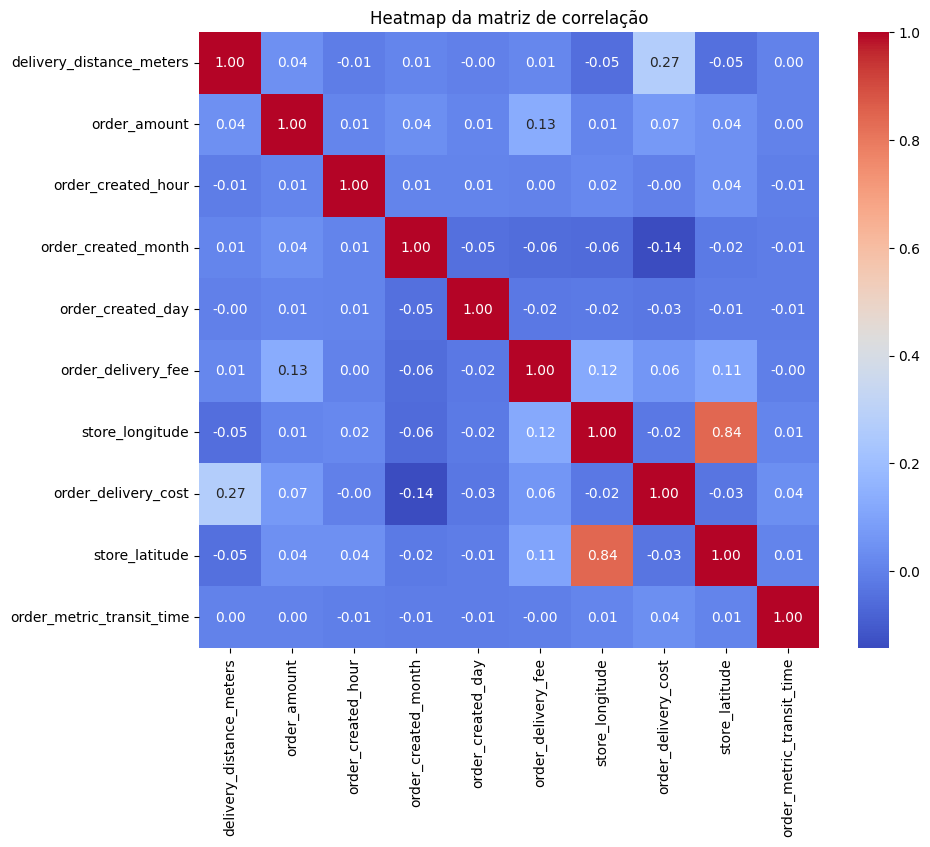

In [11]:
plt.figure(figsize=(10, 8))  # Tamanho da figura


# Substitua df pelo seu DataFrame
sns.heatmap(df_transito.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adicione um título
plt.title('Heatmap da matriz de correlação')

# Exiba o plot
plt.show()

In [178]:
nomes_colunas_numericas = df_transito.select_dtypes(exclude=['object','datetime']).columns

for coluna in nomes_colunas_numericas:
    data1 = df_transito[coluna]
    data2 = df_transito['order_metric_transit_time']

    t_statistic, p_value = ttest_ind(data1, data2)

    print("\n")
    print(coluna)
    print("Estatística t:", t_statistic)
    print("Valor p:", p_value)



hour_angle
Estatística t: 688.8038729335409
Valor p: 0.0


delivery_distance_meters
Estatística t: 789.3487707308802
Valor p: 0.0


order_amount
Estatística t: 278.85180098523773
Valor p: 0.0


order_created_hour
Estatística t: 17.67290287995023
Valor p: 7.265732446721026e-70


order_created_month
Estatística t: -653.8473450549106
Valor p: 0.0


order_created_day
Estatística t: -14.62227822852405
Valor p: 2.091811608158669e-48


order_delivery_fee
Estatística t: -443.04710843536486
Valor p: 0.0


store_longitude
Estatística t: -2856.119194941881
Valor p: 0.0


order_delivery_cost
Estatística t: -464.412817712288
Valor p: 0.0


store_latitude
Estatística t: -1881.356044924922
Valor p: 0.0


order_metric_transit_time
Estatística t: 0.0
Valor p: 1.0


Modelo

In [11]:
print(df_transito.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_transit_time = dados.pop("order_metric_transit_time")
    return dados, order_metric_transit_time

tam_div = round(0.8 * len(df_transito)) # Tamanho da separação
tab_treino = df_transito.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_transito.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

# Inicialize o modelo Random Forest
modelo_transito = RandomForestRegressor(n_estimators=100,max_depth=15, min_samples_split=10, min_samples_leaf=4,  random_state=42)

# modelo_transito = LinearRegression()

# Ajuste o modelo aos dados de treinamento
modelo_transito.fit(X_treino, Y_treino)

# Faça previsões no conjunto de teste
Y_prev_valid = modelo_transito.predict(X_valid)

# Calcule o erro quadrático médio (MSE)
mse_rf = mean_squared_error(Y_valid, Y_prev_valid)
print("MSE Random Forest:", mse_rf)

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['hour_angle', 'driver_type', 'driver_modal', 'payment_method',
       'channel_type', 'payment_amount', 'hub_longitude', 'hub_latitude',
       'store_longitude', 'store_longitude', 'store_segment',
       'delivery_distance_meters', 'order_amount', 'order_created_month',
       'order_created_day', 'order_delivery_fee', 'store_longitude',
       'store_longitude', 'order_delivery_cost', 'store_latitude',
       'order_metric_transit_time'],
      dtype='object')
MSE Random Forest: 78.46670097743905
R²: 0.19124146182830626


# Order_metric_paused_time

In [12]:
colunas_paused = ['payment_method','channel_type','store_segment','order_created_month','order_created_day','order_created_hour','order_delivery_cost','order_delivery_fee','store_latitude','order_metric_paused_time']

#Colunas

df_paused = df[colunas_paused]
df_paused = df_paused.dropna(subset=['order_metric_paused_time'])

df_paused = df_paused.loc[df_paused['order_metric_paused_time'] <= 11]
# df_production = df_production.dropna(subset=['order_delivery_cost','order_metric_production_time'])

def troca3(x):
    if x == 'FOOD':
        return 0
    else:
        return 1
    
df_paused['store_segment'] = df_paused['store_segment'].apply(lambda x: troca3(x))

def troca2(x):
    if x == 'MARKETPLACE':
        return 0
    else:
        return 1
    
df_paused['channel_type'] = df_paused['channel_type'].apply(lambda x: troca2(x))

def troca1(x):
    if x == 'ONLINE':
        return 0
    elif x == 'VOUCHER':
        return 1
    elif x == 'CARD':
        return 2
    else:
        return 3
    
df_paused['payment_method'] = df_paused['payment_method'].apply(lambda x: troca1(x))

In [13]:
print(df_paused.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_paused_time = dados.pop("order_metric_paused_time")
    return dados, order_metric_paused_time

tam_div = round(0.8 * len(df_paused)) # Tamanho da separação
tab_treino = df_paused.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_paused.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]


modelo_paused = RandomForestRegressor(n_estimators=100,max_depth=15, min_samples_split=5, min_samples_leaf=4,  random_state=42)

modelo_paused.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_paused.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²

Index(['payment_method', 'channel_type', 'store_segment',
       'order_created_month', 'order_created_day', 'order_created_hour',
       'order_delivery_cost', 'order_delivery_fee', 'store_latitude',
       'order_metric_paused_time'],
      dtype='object')
MSE: 5.963465802656394
R²: 0.12276964210971608


# Modelo Final

Agora que todos os order_metric já tem seus modelos agora é necessária a junção de todos.

Funções preparações:

Como cada modelo utilizou de colunas diferente e meios diferentes, para prever em um novo dataframe essas funções serão criadas para facilitar o processo de dataprep

In [14]:
#Production_time
def prep_production(df, modelo):
    colunas_production = ['order_created_hour','order_created_minute','channel_type','payment_method','order_delivery_fee','payment_amount','store_longitude','store_latitude','store_plan_price','order_amount']

    df_production = df[colunas_production]

    # Verificar se há valores NaN em cada coluna
    for coluna in df_production.columns:
        if df_production[coluna].isnull().any():
            df_production[coluna] = df_production[coluna].fillna(0.0)

    df_production['payment_method'] = df_production['payment_method'].apply(lambda x: troca1(x))
    
    df_production['channel_type'] = df_production['channel_type'].apply(lambda x: troca2(x))

    # Calculando a representação circular para as horas
    df_production['hour_angle'] = (df_production['order_created_hour'] % 12) * 30 + (df_production['order_created_minute'] / 60) * 30
    # Normalizando os ângulos para o intervalo [0, 360)
    df_production['hour_angle'] = df_production['hour_angle'] % 360

    colunas = df_production.columns.tolist()

    # Mover 'coluna_alvo' para o início da lista
    colunas.insert(0, colunas.pop(colunas.index('hour_angle')))

    # Reorganizar as colunas no DataFrame
    df_production = df_production[colunas]

    df_production = df_production.drop(columns=['order_created_hour','order_created_minute'])

    Y_prev = modelo.predict(df_production)
    
    return Y_prev

In [15]:
#Expedition_time

def prep_exped(df, modelo):
    colunas_exped = ['payment_method','channel_type','hub_longitude','store_segment','order_created_month','order_created_day','order_created_minute','order_created_hour','order_delivery_cost','store_latitude','store_longitude','order_delivery_fee', 'driver_type', 'store_plan_price']

    df_exped = df[colunas_exped]

    # Verificar se há valores NaN em cada coluna
    for coluna in df_exped.columns:
        if df_exped[coluna].isnull().any():
            df_exped[coluna] = df_exped[coluna].fillna(0.0)

    df_exped['driver_type'] = df_exped['driver_type'].apply(lambda x: type(x))
    
    df_exped['store_segment'] = df_exped['store_segment'].apply(lambda x: troca3(x))

    df_exped['channel_type'] = df_exped['channel_type'].apply(lambda x: troca2(x))
        
    df_exped['payment_method'] = df_exped['payment_method'].apply(lambda x: troca1(x))

    Y_prev = modelo.predict(df_exped)
    
    return Y_prev

In [36]:
#Transit_time

def prep_transito(df, modelo):
    colunas_transito = ['driver_type','driver_modal','payment_method','channel_type','payment_amount','hub_longitude','hub_latitude','store_longitude','store_segment','delivery_distance_meters','order_amount','order_created_hour','order_created_minute','order_created_month', 'order_created_day','order_delivery_fee','store_longitude','order_delivery_cost','store_latitude']

    df_transito = df[colunas_transito]

    df_transito['driver_type'] = df_transito['driver_type'].fillna(0)
    df_transito['driver_modal'] = df_transito['driver_modal'].fillna(1)
    df_transito['payment_method'] = df_transito['payment_method'].fillna(3)
    df_transito['payment_amount'] = df_transito['payment_amount'].fillna(0.0)
    df_transito['delivery_distance_meters'] = df_transito['delivery_distance_meters'].fillna(0.0)

    #Variável de ângulo da hora

    # Calculando a representação circular para as horas
    df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
    # Normalizando os ângulos para o intervalo [0, 360)
    df_transito['hour_angle'] = df_transito['hour_angle'] % 360

    colunas = df_transito.columns.tolist()

    # Mover 'coluna_alvo' para o início da lista
    colunas.insert(0, colunas.pop(colunas.index('hour_angle')))

    # Reorganizar as colunas no DataFrame
    df_transito = df_transito[colunas]

    df_transito = df_transito.drop(columns=['order_created_hour','order_created_minute'])

        
    df_transito['store_segment'] = df_transito['store_segment'].apply(lambda x: troca3(x))
        
    df_transito['channel_type'] = df_transito['channel_type'].apply(lambda x: troca2(x))
        
    df_transito['payment_method'] = df_transito['payment_method'].apply(lambda x: troca1(x))
        
    df_transito['driver_modal'] = df_transito['driver_modal'].apply(lambda x: troca4(x))
        
    df_transito['driver_type'] = df_transito['driver_type'].apply(lambda x: type(x))

    Y_prev = modelo.predict(df_transito)

    return Y_prev

In [17]:
def prep_paused(df, modelo):
    colunas_paused = ['payment_method','channel_type','store_segment','order_created_month','order_created_day','order_created_hour','order_delivery_cost','order_delivery_fee','store_latitude']

    df_paused = df[colunas_paused]
    
    df_paused['store_segment'] = df_paused['store_segment'].apply(lambda x: troca3(x))
        
    df_paused['channel_type'] = df_paused['channel_type'].apply(lambda x: troca2(x))
        
    df_paused['payment_method'] = df_paused['payment_method'].apply(lambda x: troca1(x))

    for coluna in df_paused.columns:
        if df_paused[coluna].isnull().any():
            df_paused[coluna] = df_paused[coluna].fillna(0.0)

    Y_prev = modelo.predict(df_paused)

    return Y_prev

In [75]:
print(df_payments['payment_order_id'].value_counts().unique())

[1]


In [18]:
# Remover as linhas duplicadas com base na coluna 'order_id'
df_payments = df_payments.drop_duplicates(subset=['payment_order_id'])
df_drivers = df_drivers.drop_duplicates(subset=['driver_id'])
df_deliveries = df_deliveries.drop_duplicates(subset=['delivery_order_id'])

In [19]:
df_test = pd.read_csv(r'test.csv')


df_test = pd.merge(df_test, df_stores, on='store_id')
df_test = pd.merge(df_test, df_hubs, on='hub_id')
df_test = pd.merge(df_test, df_channels, on='channel_id')
df_test = pd.merge(df_test, df_payments, on='payment_order_id', how='left')
df_test = pd.merge(df_test, df_deliveries, on='delivery_order_id', how='left')
df_test = pd.merge(df_test, df_drivers, on='driver_id', how='left')

df_test.shape

(84107, 35)

In [20]:
def preparacao_inicial(df):

    #Retirar colunas não importantes
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id'])

    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status','payment_fee'])

    df['store_latitude'] = df['store_latitude'].fillna(df['store_latitude'].mean())
    df['store_longitude'] = df['store_longitude'].fillna(df['store_longitude'].mean())

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)
    
    return df

In [21]:
df_test = preparacao_inicial(df_test)

df_test.shape

outlier_df = conta_outliers(df_test)
print(outlier_df)

                      Coluna  Outliers  Porcentagem       lim_inf  \
0                   order_id         0     0.000000  5.817301e+07   
1               order_amount      3445     4.095973 -7.575000e+01   
2         order_delivery_fee        16     0.019023 -1.785000e+01   
3        order_delivery_cost      1647     1.958220  7.750000e-01   
4         order_created_hour      7522     8.943370  4.500000e+00   
5       order_created_minute         0     0.000000 -2.850000e+01   
6          order_created_day         0     0.000000 -1.200000e+01   
7        order_created_month         0     0.000000 -1.000000e+00   
8         order_created_year         0     0.000000  2.021000e+03   
9           store_plan_price         0     0.000000 -7.350000e+01   
10            store_latitude     14695    17.471792 -2.459776e+01   
11           store_longitude         0     0.000000 -5.174701e+01   
12              hub_latitude     14717    17.497949 -2.460267e+01   
13             hub_longitude      

In [37]:
y_pred_production = prep_production(df_test,modelo_production)
print(len(y_pred_production))
y_pred_exped = prep_exped(df_test,modelo_exped)
print(len(y_pred_exped))
y_pred_transito = prep_transito(df_test,modelo_transito)
y_pred_paused = prep_paused(df_test,modelo_paused)
print(len(y_pred_transito))

order_metric_cycle_time = []

for k in range(len(y_pred_transito)):
    # Calcular a soma dos valores das três colunas mais a mediana para cada índice k
    cycle_time = y_pred_transito[k] + y_pred_exped[k] + y_pred_production[k] + median + y_pred_paused[k]
    # Adicionar o resultado à lista
    order_metric_cycle_time.append(cycle_time)

84107
84107
84107


In [38]:
data = {'order_id': df_test['order_id'], 'order_metric_cycle_time': order_metric_cycle_time}
df_result = pd.DataFrame(data)

# Salvar o DataFrame em um arquivo CSV
df_result.to_csv('resultado.csv', index=False)